# Calculate 0th-order 3BR widths
Reference: Petit et al. (2020) https://doi.org/10.1051/0004-6361/202038764

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from celmech.disturbing_function import laplace_b as b
import cmath
from scipy.optimize import fsolve
from sympy import Symbol, solve
import rebound
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')

In [2]:
def zerothOrder(P12,mass,p,q):
    m1,m2,m3 = mass
    P23 = 1-p/q*(1/P12-1)
    a12, a23 = P12**(2/3), P23**(2/3)
    eta, nu = p/(p+q), (1-P12)*(1-P23)/(1-P12*P23)
    epsM = np.sqrt(m1*m3+m2*m3*eta**2/a12**2+m1*m2*a23**2*(1-eta)**2)
    delta = (1-a12)*(1-a23)/(1-a12+1-a23)
    DeltaEta = 6.55*epsM*(eta*(1-eta))**(3/2)/delta**2*np.exp(-(p+q)*delta)
    
    Delta12 = nu/(eta+nu)**2*DeltaEta
    Delta23 = -nu/(1-eta)**2*DeltaEta
    return abs(Delta12), abs(Delta23)

# Calculate 1st-order 3BR widths
Reference: Petit (2021) https://doi.org/10.1007/s10569-021-10035-7

In [3]:
# Eqs.(51a)-(51e) in Appendix A
def f2(l,a):
    return 1/8 *(-4*l**2*b(1/2,l,0,a) + 2*a*b(1/2,l,1,a) + a**2*b(1/2,l,2,a))
def f10(l,a):
    return -1/4* ((-4*l**2-6*l-2)*b(1/2,l+1,0,a) + 2*a*b(1/2,l+1,1,a) + a**2*b(1/2,l+1,2,a))
def f45(l,a):
    return 1/8* ((4*l**2+11*l+6)*b(1/2,l+2,0,a) + (4*l+6)*a*b(1/2,l+2,1,a) + a**2*b(1/2,l+2,2,a))
def f49(l,a):
    return -1/4* ((4*l**2+10*l+6)*b(1/2,l+1,0,a) + (4*l+6)*a*b(1/2,l+1,1,a) + a**2*b(1/2,l+1,2,a))
def f53(l,a):
    return 1/8* ((4*l**2+6*l+4)*b(1/2,l,0,a) + (4*l+6)*a*b(1/2,l,1,a) + a**2*b(1/2,l,2,a))

In [4]:
# Eqs.(57a)-(58b) in Appendix C
def g1l(k1,k3,a12,a23):
    def b12(k,n=0):
        return b(1/2,k,n,a12)
    def b23(k,n=0):
        return b(1/2,k,n,a23)
    
    nu12, nu23 = a12**(3/2), a23**(3/2)
    
    line1 = 1/(1-nu23)*((1-k1)*b12(1-k1)*b23(k3) 
                      + (2-k1)*a12*(b12(1-k1)*b23(k3,1) + b12(1-k1,1)*b23(k3)) # 1st-order deriv
                      + a12**2/2*(b12(1-k1,2)*b23(k3) + 2*b12(1-k1,1)*b23(k3,1) + b12(1-k1)*b23(k3,2)) # 2nd-order deriv
                      + (k1-1)/k3*(3/(2-2*nu23)*b23(k3) + a23*b23(k3,1)) * ((1-k1)*b12(1-k1) + a12/2*b12(1-k1,1))) # end of square bracket
    line2 = + f10(k1,a12)/(k1*(1/nu12-1)) * (k3*b23(k3) + a23/2*b23(k3,1))
    line3 = - f49(-k1,a12)/(k3+1-k3*nu23) * (-k3*b23(-k3) + a23/2*b23(-k3,1))
    return line1+line2+line3

def g1g(k1,k3,a12,a23):
    def b12(k,n=0):
        return b(1/2,k,n,a12)
    def b23(k,n=0):
        return b(1/2,k,n,a23)
    
    nu12, nu23 = a12**(3/2), a23**(3/2)
    
    line1 = 1/(1-nu23) * ((1-10*k1)/8*b12(-k1)*b23(k3) 
                        + (13/8-k1)*a12*(b12(-k1)*b23(k3,1) + b12(-k1,1)*b23(k3))
                        + a12**2/2*(b12(-k1,2)*b23(k3) + 2*b12(-k1,1)*b23(k3,1) + b12(-k1)*b23(k3,2))
                        + (k1-1)/k3*(3/(2-2*nu23)*b23(k3) + a23*b23(k3,1)) * ((1/2-k1)*b12(-k1) + a12/2*b12(-k1,1)))
    line2 = - f2(k1,a12)/(k1*(1/nu12-1)) * (k3*b23(k3) + a23/2*b23(k3,1))
    line3 = + 2*f53(-k1,a12)/(k3+1-k3*nu23) * (-k3*b23(-k3) + a23/2*b23(-k3,1))
    return line1+line2+line3

def g3l(k1,k3,a12,a23):
    def b12(k,n=0):
        return b(1/2,k,n,a12)
    def b23(k,n=0):
        return b(1/2,k,n,a23)
    
    nu12, nu23 = a12**(3/2), a23**(3/2)
    
    line1 = 1/(1/nu12-1) * ((k3-3)/4*b23(k3)*b12(k1)
                            + (k3+3/8)*a23 * (b23(k3)*b12(k1,1) + b23(k3,1)*b12(k1))
                            + a23**2/2 * (b23(k3,2)*b12(k1) + 2*b23(k3,1)*b12(k1,1) + b23(k3)*b12(k1,2))
                            + (k3-1)/k1*(3/(2/nu12-1)*b12(k1) + a12*b12(k1,1)) * (k3*b23(k3) + a23/2*b23(k3,1)))
    line2 = + f2(-k3,a23)/(k3*(1-nu23)) * ((1/2-k1)*b12(k1) + a12/2*b12(a12,1))
    line3 = - 2*f45(k3-2,a23)/(k1/nu12-k1-1) * ((k1+1/2)*b12(k1) + a12/2*b12(k1,2))
    return line1+line2+line3

def g3g(k1,k3,a12,a23):
    def b12(k,n=0):
        return b(1/2,k,n,a12)
    def b23(k,n=0):
        return b(1/2,k,n,a23)
    
    nu12, nu23 = a12**(3/2), a23**(3/2)
    
    line1 = 1/(1/nu12-1) * (k3*a23*(b23(k3)*b12(k1,1) + b23(k3,1)*b12(k1))
                            + a23**2/2* (b23(k3,2)*b12(k1) + 2*b23(k3,1)*b12(k1,1) + b23(k3)*b12(k1,2))
                            + (k3-1)/k1 * (3/(2/nu12-2)*b12(k1) + a12*b12(k1,1)) * ((k3-1/2)*b23(k3) + a23/2*b23(k3,1)))
    line2 = - f2(-k3,a23)/(k3*(1-nu23)) * ((1/2-k1)*b12(k1) + a12/2*b12(k1,1))
    line3 = + f49(k3-2,a23)/(k1/nu12-k1-1) * ((k1+1/2)*b12(k1) + a12/2*b12(k1,1))
    return line1+line2+line3

## code to reproduce Fig.(4b)

In [5]:
k1, k2, k3 = -3, 6, -2
m1, m2, m3, m0 = 1e-4, 1e-4, 1e-4, 1
P23 = 0.65
P12 = 1/(k3/k1*(1-1/k3-P23)+1)
P1, P2, P3 = 1, 1/P12, 1/(P12*P23)
a1, a2, a3 = P1**(2/3), P2**(2/3), P3**(2/3)
a12, a23 = a1/a2, a2/a3
n1, n2, n3 = 2*np.pi/P1, 2*np.pi/P2, 2*np.pi/P3
eps = 3*1e-4

Lambda1, Lambda2, Lambda3 = m1*np.sqrt(sim.G*m0*a1), m2*np.sqrt(sim.G*m0*a2), m3*np.sqrt(sim.G*m0*a3)
G1L,G1G,G3L,G3G = g1l(k1,k3,a12,a23), g1g(k1,k3,a12,a23), g3l(k1,k3,a12,a23), g3g(k1,k3,a12,a23)
gtilde = np.sqrt(2/Lambda1*G1L**2 + 2/Lambda2*(G1G-G3L)**2 + 2/Lambda3*G3G**2)
R = sim.G/(2*a3)*(m1*m2*m3/m0)/eps**2 * gtilde
K2 = 3*(n1*k1**2/Lambda1 + n2*k2**2/Lambda2 + n3*k3**2/Lambda3)
kappa = np.sqrt(2)*R/K2  # Eq.(40)

def width(e2):
    e1 = abs((G1L*Lambda2/Lambda1 + G3G*Lambda2/Lambda1) / (G1L*(G1G-G3L)+ G3G*(G1G-G3L)*G3G/G1L*Lambda1/Lambda3)) * e2
    e3 = G3G/G1L*Lambda1/Lambda3 * e1
    C1, C2, C3 = Lambda1*(1-np.sqrt(1-e1**2)), Lambda2*(1-np.sqrt(1-e2**2)), Lambda3*(1-np.sqrt(1-e3**2))
    DeltaG = C1 + C2 + C3  # Lambda,0 = Lambda
    I0 = (eps**2*kappa)**(-2/3)*DeltaG
    if I0 > 3/2:
        X3 = 2*np.sqrt(2*I0/3)*np.cos(1/3*np.arccos((3/(2*I0))**(3/2))-4*np.pi/3)
    elif I0 != 0:
        X3 = 2*np.sqrt(2*I0/3)*np.cos(1/3*np.arccosh((3/(2*I0))**(3/2)))
    else:
        X3 = 2**(1/3)
        
    DeltaI = 4 * (eps**2*kappa)**(2/3) * np.sqrt(abs(X3))
    X1, X2 = -X3+2/np.sqrt(abs(X3)), -X3-2/np.sqrt(abs(X3))
    
    # the location of the separatrix in terms of P12
    sep1 = 3*P12*abs(k1/Lambda1-k2/Lambda2)*(X1**2/2*(eps**2*kappa)**(2/3)-DeltaG)
    sep2 = 3*P12*abs(k1/Lambda1-k2/Lambda2)*(X2**2/2*(eps**2*kappa)**(2/3)-DeltaG)
    return sep1, sep2

(0.0, 0.04)

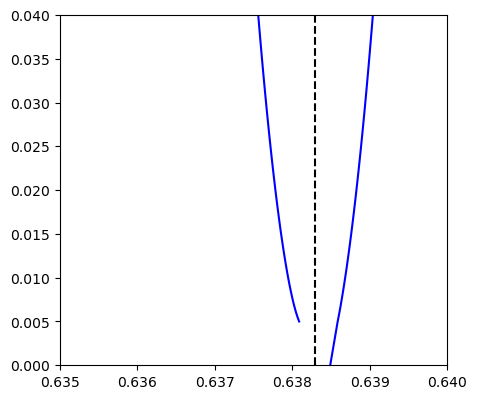

In [6]:
sep1, sep2 = np.zeros(100), np.zeros(100)
ecc2 = np.linspace(0.005,0.04,100)
for i, e2 in enumerate(ecc2):
    sep1[i], sep2[i] = width(e2)
w_circ = 3*P12*abs(k1/Lambda1-k2/Lambda2)*4*2**(1/6)*(eps**2*kappa)**(2/3)
    
fig, ax = plt.subplots(figsize=(10/2,9.1/2))
ax.plot(np.concatenate(([P12+w_circ/2],sep1+P12)), np.concatenate(([0], ecc2)), color='b')
ax.plot(sep2+P12, ecc2, color='b')
ax.vlines(P12,0,0.04,'k',linestyle='--')
ax.set_xlim([0.635,0.640])
ax.set_ylim([0,0.04])

## calculate the width of an arbitrary 1st-order 3BR

From Eqs.(32)-(36), we define
$$\tilde{g} = \sqrt{\frac{2}{\Lambda_1}(g_{1<})^2 + \frac{2}{\Lambda_2}(g_{1>}-g_{3<})^2 + \frac{2}{\Lambda_3}(g_{3>})^2},$$
such that
$$r_1 = -\frac{R_{1<}}{R}\sqrt{\frac{2}{\Lambda_1}} = -\frac{g_{1<}}{\tilde{g}}\sqrt{\frac{2}{\Lambda_1}}, \qquad 
r_2 = \frac{g_{1>}-g_{3<}}{\tilde{g}}\sqrt{\frac{2}{\Lambda_2}}, \qquad
r_3 = \frac{g_{3>}}{\tilde{g}}\sqrt{\frac{2}{\Lambda_3}}$$

In [7]:
def firstOrder(P12,mass,ecc,pom,k1,k3):
    P23 = 1-1/k3-k1/k3*(1/P12-1)
    
    # ------------------ skip the systems that are on primary resonances ------------------
    res_ratio1 = [round(x/(x+1),3) for x in range(1,20)]
    res_ratio2 = [round(x/(x+2),3) for x in range(1,20)]
    exclude = np.concatenate((res_ratio1,res_ratio2))
    if round(P12,3) in exclude or round(P23,3) in exclude or round(P12*P23,3) in exclude:
        return 0,0
    
    # ------------------ initialize a simulation to ease calculation ------------------
    m1,m2,m3 = mass
    e1, e2, e3 = ecc
    pom1, pom2, pom3 = pom
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')
    sim.add(m=1.)
    sim.add(m=m1, P=1, e=e1, pomega=pom1)
    sim.add(m=m2, P=1/P12, e=e2, pomega=pom2)
    sim.add(m=m3, P=1/(P12*P23), e=e3, pomega=pom3)
    ps = sim.particles
    a1, a2, a3 = [p.a for p in ps[1:]]
    n1, n2, n3 = [2*np.pi/(p.P) for p in ps[1:]]
    e1, e2, e3 = [p.e*cmath.exp(1j*p.pomega) for p in ps[1:]]
    
    # ------------------ Start Calculation ------------------
    eps = m1+m2+m3
    Lambda1, Lambda2, Lambda3 = m1*np.sqrt(sim.G*a1), m2*np.sqrt(sim.G*a2), m3*np.sqrt(sim.G*a3)
    a12, a23 = a1/a2, a2/a3
    k2 = 1-k1-k3
    G1L,G1G,G3L,G3G = g1l(k1,k3,a12,a23), g1g(k1,k3,a12,a23), g3l(k1,k3,a12,a23), g3g(k1,k3,a12,a23)
    gtilde = np.sqrt(2/Lambda1*G1L**2 + 2/Lambda2*(G1G-G3L)**2 + 2/Lambda3*G3G**2)  # see the markdown above
    R = sim.G/(2*a3)*(m1*m2*m3)/eps**2 * gtilde
    K2 = 3*(n1*k1**2/Lambda1 + n2*k2**2/Lambda2 + n3*k3**2/Lambda3)  # Eq.(39)
    kappa = np.sqrt(2)*R/K2  # Eq.(40) in the paper should not have eps^2 at the front

    C1, C2, C3 = Lambda1*(1-np.sqrt(1-np.abs(e1)**2)), Lambda2*(1-np.sqrt(1-np.abs(e2)**2)), Lambda3*(1-np.sqrt(1-np.abs(e3)**2))
    DeltaG = C1 + C2 + C3
    
    # Eq.(34)
    r1 = -G1L/gtilde*np.sqrt(2/Lambda1)
    r2 = (G1G-G3L)/gtilde*np.sqrt(2/Lambda2)
    r3 = G3G/gtilde*np.sqrt(2/Lambda3)
    rotation = np.array([[r1, r2, r3],
                         [r3/np.sqrt(1-r2**2), 0, -r1/np.sqrt(1-r2**2)],
                         [r1*r2/np.sqrt(1-r2**2), (r2**2-1)/np.sqrt(1-r2**2), r2*r3/np.sqrt(1-r2**2)]])
    x_vec = np.array([[np.sqrt(C1)*e1], [np.sqrt(C2)*e2], [np.sqrt(C3)*e3]])
    y_vec = rotation @ x_vec
    I1, I2, I3 = np.abs(y_vec[0][0])**2, np.abs(y_vec[1][0])**2, np.abs(y_vec[2][0])**2
    
    # see text below Eq.(40)
    I0 = (eps**2*kappa)**(-2/3)*(DeltaG-I2-I3)
    if I0 < 3/2:
        w_circ = 3*P12*abs(k1/Lambda1-k2/Lambda2)*4*2**(1/6)*(eps**2*kappa)**(2/3)  # width in the circular case
        return w_circ, w_circ
    X3 = 2*np.sqrt(2*I0/3)*np.cos(1/3*np.arccos((3/(2*I0))**(3/2))-4*np.pi/3)
    DeltaI = 4 * (eps**2*kappa)**(2/3) * np.sqrt(abs(X3))  # Eq.(43)
    
    # widths in terms of P12 and P23
    Delta12 = 3*P12*abs(k1/Lambda1-k2/Lambda2)*DeltaI
    Delta23 = 3*P23*abs(k2/Lambda2-k3/Lambda3)*DeltaI
    
    return abs(Delta12), abs(Delta23)

# Plot and compare the widths of 0th-order and 1st-order 3BR

In [8]:
MASS = 1e-4, 1e-4, 1e-4
ECC = 0.02, 0.02, 0.02
POMEGA = 0, 0, 0

In [9]:
param = [[x,y] for x in range(2,30) for y in range(2,30)]
P12, P23, w0, h0, P, Q = [], [], [], [], [], []
for p, q in param:
    for p12 in np.linspace(0.5,0.95,400):
        p23 = 1-p/q*(1/p12-1)
        if p23 <= 0.95 and p23 >= 0.5:
            w, h = zerothOrder(p12,MASS,p,q)
            w0 = w0 + [w]
            h0 = h0 + [h]
            P12 = P12 + [p12]
            P23 = P23 + [p23]
            P = P + [p]
            Q = Q + [q]

In [10]:
param = [[x,y] for x in range(1,20) if x!=0 for y in range(1,20) if y!=0]
nu12, nu23, w1, h1, K1, K3 = [], [], [], [], [], []
for k1, k3 in param:
    for p12 in np.linspace(0.5,0.9,100):
        p23 = 1-1/k3-k1/k3*(1/p12-1)
        if p23 <= 0.9 and p23 >= 0.5:
            w, h = firstOrder(p12,MASS,ECC,POMEGA,k1,k3)
            w1 = w1 + [w]
            h1 = h1 + [h]
            nu12 = nu12 + [p12]
            nu23 = nu23 + [p23]
            K1 = K1 + [k1]
            K3 = K3 + [k3]

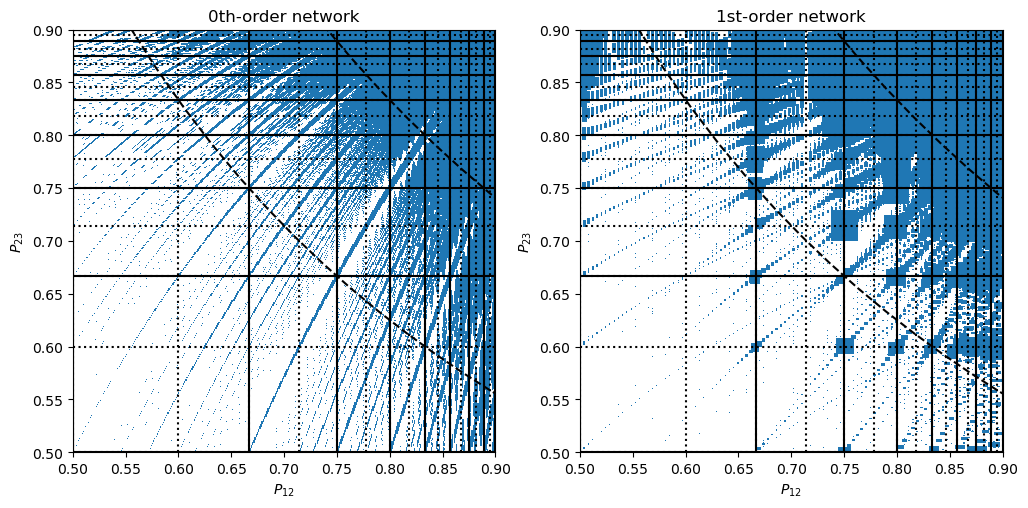

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
points0 = [plt.Rectangle((P12[i]-w0[i]/2,P23[i]-h0[i]/2), w0[i], h0[i]) for i in range(len(P12))]
rec0 = matplotlib.collections.PatchCollection(points0)
ax1.add_collection(rec0)
ax1.set_title("0th-order network")
points1 = [plt.Rectangle((nu12[i]-w1[i]/2,nu23[i]-h1[i]/2), w1[i], h1[i]) for i in range(len(nu12))]
rec1 = matplotlib.collections.PatchCollection(points1)
ax2.add_collection(rec1)
ax2.set_title("1st-order network")

res_ratio1 = [round(x/(x+1),3) for x in range(1,20)]
res_ratio2 = [round(x/(x+2),3) for x in range(1,20)]
for ax in [ax1,ax2]:
    ax.vlines(res_ratio1,0.5,0.9,color='k',linestyle='-')
    ax.vlines(res_ratio2,0.5,0.9,color='k',linestyle=':')
    ax.hlines(res_ratio1,0.5,0.9,color='k',linestyle='-')
    ax.hlines(res_ratio2,0.5,0.9,color='k',linestyle=':')
    ax.plot(np.linspace(0.5,1,20),1/2/np.linspace(0.5,1,20),color='k',linestyle='--')
    ax.plot(np.linspace(0.5,1,20),2/3/np.linspace(0.5,1,20),color='k',linestyle='--')
    
    ax.set_aspect('equal')
    ax.set_ylim([0.5,0.9])
    ax.set_xlim([0.5,0.9])
    ax.set_xlabel("$P_{12}$")
    ax.set_ylabel("$P_{23}$")